<a href="https://colab.research.google.com/github/kgreed4/no_hate_transformer/blob/dombuford/encoder_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import math
from numpy import random
from transformers import BertTokenizer
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
#input embeddings

class InputEmbeddings(nn.Module):
  def __init__(self, embedding_size:int, vocab_size:int):
    super().__init__()
    self.embedding_size = embedding_size
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, embedding_size)

  def forward(self, x):
    return self.embedding(x)* math.sqrt(self.embedding_size)


In [ ]:
# positional encoding

class PositionalEncoding(nn.Module):
  def __init__(self, embedding_size, seq_len, dropout):
    super().__init__()
    self.embedding_size = embedding_size
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    #need a matrix of size (seq_len, embedding_size)
    self.positionalEncoding = torch.zeros(seq_len, embedding_size)

    #create a vector of shape seq_len
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    dividing_term = torch.exp(torch.arange(0, embedding_size, 2).float()* (-math.log(10000.0)/embedding_size))

    #apply sin to even positions in the encoding and cosine to the odd positions
    self.positionalEncoding[:, 0::2] = torch.sin(position * dividing_term)
    self.positionalEncoding[:, 1::2] = torch.cos(position * dividing_term)

    #add batch dimension to positionalEncoding matrix
    self.positionalEncoding = self.positionalEncoding.unsqueeze(0)

   # self.register_buffer('positionalEncoding',self.positionalEncoding) #the tensor will now be saved in the file

  def forward(self, x):
    x = x +(self.positionalEncoding[:, :x.shape[1], :]).requires_grad_(False)
    return self.dropout(x)

In [ ]:
#layer normalization
class LayerNormalization(nn.Module):
  def __init__(self, eps:float):
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1))
    self.bias = nn.Parameter(torch.zeros(1))
  def forward(self, x):
    mean = x.mean(dim = -1, keepdim= True)
    std = x.std(dim = -1, keepdim = True)
    return self.alpha * (x - mean)/(std + self.eps) + self.bias

In [ ]:
#feed forward layer
class FeedForward(nn.Module):
  def __init__(self, embedding_size:int, d_ff:int, dropout:float):
    super().__init__()
    self.embedding_size = embedding_size
    self.d_ff = d_ff
    self.dropout = nn.Dropout(dropout)
    self.linear_1 = nn.Linear(embedding_size, d_ff)
    self.linear_2 = nn.Linear(d_ff, embedding_size)
  def forward(self, x):
   # x dimensions are (batch_size, seq_len, embedding_size)
    x = self.linear_1(x)
    x = torch.relu(x)
    x = self.dropout(x)
    x = self.linear_2(x)
    return x


In [ ]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self, num_heads, embedding_size, dropout):
    super().__init__()
    self.num_heads = num_heads
    self.embedding_size = embedding_size
    self.dropout =nn.Dropout(dropout)
    assert embedding_size % num_heads == 0, "embedding_size is not divisible by num of heads" #so that the embedding can be divided equally into number of heads there are
    self.d_k = int(embedding_size/num_heads)

    self.W_q = nn.Linear(embedding_size, embedding_size)
    self.W_k = nn.Linear(embedding_size, embedding_size)
    self.W_v = nn.Linear(embedding_size, embedding_size)
    self.W_o = nn.Linear(embedding_size, embedding_size)

  def forward(self, q, k, v):
    query  = self.W_q(q)  #(Batch, seq_len, embedding_size)--> (Batch, seq_len, embedding_size)
    key = self.W_k(k)     #(Batch, seq_len, embedding_size)--> (Batch, seq_len, embedding_size)
    value = self.W_v(v)   #(Batch, seq_len, embedding_size)--> (Batch, seq_len, embedding_size)

    query = query.view(query.shape[0], query.shape[1], self.num_heads, self.d_k).transpose(1, 2)  #dividing up for num of heads
    key = key.view(key.shape[0], key.shape[1], self.num_heads, self.d_k).transpose(1, 2)
    value = value.view(value.shape[0], value.shape[1], self.num_heads, self.d_k).transpose(1,2)

    #calculate attention scores and
    x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, self.dropout)

    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.num_heads * self.d_k)  #(batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k)--> (batch, seq_len, embedding_size)

    return self.W_o(x)

  @staticmethod
  def attention(query, key, value, dropout):
    d_k = query.shape[-1]

    attention_scores = (query @ key.transpose(-2, -1))/math.sqrt(d_k)
    attention_scores = attention_scores.softmax(dim = -1)  #(Batch, num_heads, seq_len, seq_len)
    if dropout is not None:
      attention_scores = dropout(attention_scores)

    return (attention_scores @value), attention_scores



In [ ]:
#define the encoder layer
class EncoderLayer(nn.Module):
  def __init__(self, embedding_size, num_heads, d_ff, dropout, eps): #will need to update inputs
    super().__init__()
    self.multiHeadAttention = MultiHeadAttentionBlock(num_heads, embedding_size, dropout)
    self.feedForward = FeedForward(embedding_size, d_ff, dropout)
    self.layerNormalization = nn.ModuleList(LayerNormalization(eps) for _ in range(2))
  def forward(self, x):
    multi_head_output = self.multiHeadAttention(x, x, x)
    add_norm_output_1 = self.layerNormalization[0](x + multi_head_output) #adding for purpose of residual connections
    feed_forward_output = self.feedForward(add_norm_output_1)
    add_norm_output_2 = self.layerNormalization[1](add_norm_output_1 + feed_forward_output)

    return add_norm_output_2


In [ ]:
class Encoder(nn.Module):
  def __init__(self, n, num_heads, embedding_size, vocab_size, seq_len, d_ff, dropout, eps):
    super().__init__()
    self.inputEmbeddings = InputEmbeddings(embedding_size, vocab_size)
    self.pe = PositionalEncoding(embedding_size, seq_len, dropout)
    self.encoderLayer = nn.ModuleList([EncoderLayer(embedding_size, num_heads, d_ff, dropout, eps) for _ in range(n)])
  def forward(self, x):
    x = self.inputEmbeddings(x)
    x = self.pe(x)
    for i, layer in enumerate(self.encoderLayer):
      x = layer(x)
    return x


In [ ]:
class Classifier(nn.Module):
  def __init__(self, encoder:Encoder, input_size):
    super().__init__()
    self.encoder = encoder
    self.finalLayer = nn.Linear(input_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, inputs, masks):
    encoder_output = self.encoder(inputs)
    pooling_output = F.adaptive_avg_pool1d(encoder_output, 1)
    pooling_output = pooling_output.view(pooling_output.size(0), -1)
    final_output = self.finalLayer(pooling_output)
    return self.sigmoid(final_output)

In [ ]:
# We will create a small function that will take care of tokenization and encoding
def encode_texts(tokenizer, texts, max_length):
    encoding = tokenizer.batch_encode_plus(
        texts,
        # This is required to add special tokens such as the [CLS] and [SEP] tokens that indicate the start and end of a sentence
        add_special_tokens=True,
        # Here the padding variable is responsible for padding the sequences to the same length
        padding='max_length',
        # The max length of the tokenized sequences
        max_length=max_length,
        return_attention_mask=True,
        # Here we specify that we want the output to be TensorFlow tensors
        return_tensors='pt',
        # If the sequence is longer than max_length, it will be truncated to a fixed length
        truncation=True
    )
    # The encoding['input_ids'] contains the tokenized sequences
    # The encoding['attention_mask'] contains the attention masks and tells the model which tokens to pay attention to and which ones to ignore (mask token)
    return encoding['input_ids'], encoding['attention_mask']

In [ ]:
# Load the dataset
df = pd.read_csv('cleaned_data_nosw.csv')

# First, we want to use the BERT tokenizer to tokenize and encode the dataset into embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



# Here we define the maximum length (randomly chosen per ChatGPT's recommendation)
max_length = 128

# We can then call the function to tokenize and encode the dataset
input_ids, attention_masks = encode_texts(tokenizer, df['tweet'].astype(str).tolist(), max_length)

# Here we create labels from the 'class' column
# This is the target variable that we want to predict
labels = torch.tensor(df['class'].values, dtype=torch.int32).numpy()

# For some reason, I was getting an error saying that I needed to convert to NumPy arrays instead of TensorFlow tensors
# So I converted the input_ids and attention_masks to NumPy arrays
input_ids_np = input_ids.numpy()
attention_masks_np = attention_masks.numpy()

# We can then use the train_test_split function from scikit-learn to split the dataset into training and validation sets
train_inputs_np, validation_inputs_np, train_labels_np, validation_labels_np = train_test_split(input_ids_np, labels, random_state=2021, test_size=0.1)
train_masks_np, validation_masks_np, _, _ = train_test_split(attention_masks_np, labels, random_state=2021, test_size=0.1)

# Here the BUFFER_SIZE is the number of training inputs
BUFFER_SIZE = len(train_inputs_np)
# The batch size is 32
BATCH_SIZE = 32

train_inputs_tensor = torch.tensor(train_inputs_np, dtype=torch.int64)
train_masks_tensor = torch.tensor(train_masks_np, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels_np, dtype=torch.float32)
val_inputs_tensor = torch.tensor(validation_inputs_np, dtype=torch.int64)
val_masks_tensor = torch.tensor(validation_masks_np, dtype=torch.float32)
val_labels_tensor = torch.tensor(validation_labels_np, dtype=torch.float32)

train_dataset = TensorDataset(train_inputs_tensor, train_masks_tensor, train_labels_tensor)
validation_dataset = TensorDataset(val_inputs_tensor, val_masks_tensor, val_labels_tensor)


n = 4
num_heads = 8
embedding_size = 512
vocab_size = tokenizer.vocab_size + 2
seq_len = 128
d_ff = 512
dropout = 0.1
eps = 10**-6
batch_size = 32


encoder = Encoder(n, num_heads, embedding_size, vocab_size, seq_len, d_ff, dropout, eps)

model = Classifier(encoder, seq_len)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Assuming criterion is your loss function and optimizer is your optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training the model
num_epochs = 2
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, masks, labels in train_dataloader:
        optimizer.zero_grad()

        # Assuming forward method returns logits
        outputs = model(inputs, masks)

        # Compute loss
        labels = labels.reshape(BATCH_SIZE, 1)
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Count correct predictions for accuracy
        _, predicted = torch.max(outputs, 0)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate training accuracy and loss
    train_accuracy = correct_predictions / total_samples
    print(train_accuracy)
    train_loss = total_loss / len(train_dataloader)

    model.eval()
    with torch.no_grad():
      validation_loss = 0.0
      correct_predictions_val = 0
      total_samples_val = 0

      for inputs_val, masks_val, labels_val in validation_dataloader:
        outputs_val = model(inputs_val, masks_val)
        outputs_val = outputs_val.view(-1)  # Flatten the predictions tensor
        outputs_val = outputs_val.squeeze()  # Remove singleton dimensions if any
        outputs_val = outputs_val.type(torch.float32)  # Convert to float32 if not already

        loss_val = criterion(outputs_val, labels_val)
        validation_loss += loss_val.item()

        _, predicted_val = torch.max(outputs_val, 0)
        correct_predictions_val += (predicted_val == labels_val).sum().item()
        total_samples_val += labels_val.size(0)

    # Calculate validation accuracy and loss
    validation_accuracy = correct_predictions_val / total_samples_val
    validation_loss /= len(validation_dataloader)

    print(f'Epoch {epoch + 1}/{num_epochs}: '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')

    # Store values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

0.8331689383070301
Epoch 1/2: Training Loss: 0.0000, Training Accuracy: 0.8332, Validation Loss: 19.6003, Validation Accuracy: 0.8217
0.8331689383070301
Epoch 2/2: Training Loss: 0.0000, Training Accuracy: 0.8332, Validation Loss: 19.6003, Validation Accuracy: 0.8217


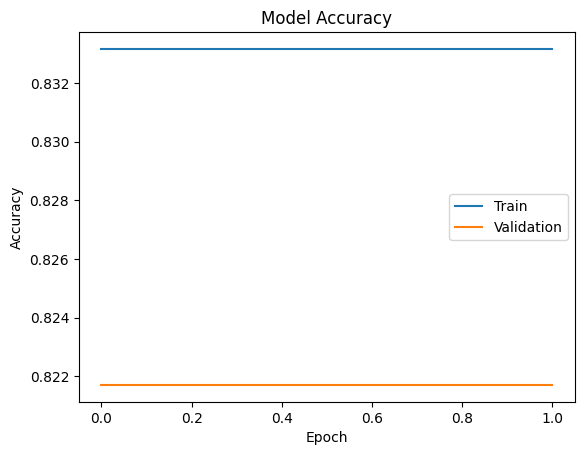

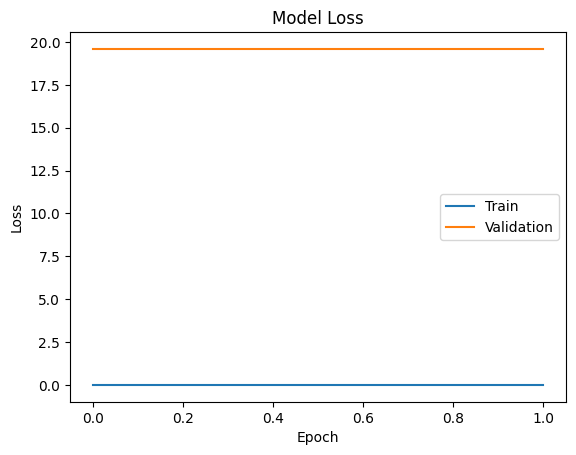

In [ ]:
#https://www.youtube.com/watch?v=ISNdQcPhsts&t=3027s